In [1]:
import pandas as pd
import re
import os
import importlib
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
warnings.simplefilter('always')

from scripts.a_data_loading_cleaning import run_load_clean_diagnose_data

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

To do
- [ ] segment all of this by model -> run the whole process separately by creating separate dfs per model
- [ ] aggregate multiple runs correctly: identify unique configs, then take mean across all configs, plot mean and each version of the config (but visually distinct), and plot scatter plot, where the mean is c of all results metrics for tha

# Data Loading & Cleaning

In [2]:
csv_path = "results/controlled_results_in_progress_18_04.csv"
df = run_load_clean_diagnose_data(csv_path)

✅ All rows have consistent 'total_generated_tokens' = 16384
----------------------------------------------------------------------------------------------------
✅ FLOPs value is constant: 16949970993152
Original distribution:
flops
16949970993152    321
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
✅ Total generated tokens value is constant: 16384
Original distribution:
total_generated_tokens
16384    321
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------


# Exploratory Data Analysis (EDA)

📊 Plotting histogram...


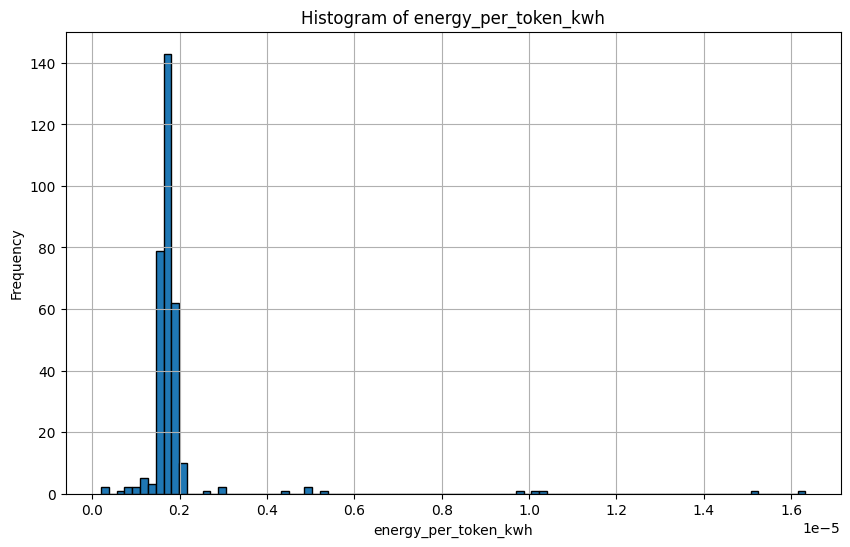

📦 Plotting boxplot...


/Users/henrybaker/repositories/thesis_analysis/scripts/b_exploratory_data_analysis.py:28: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  plt.boxplot(data[column].dropna(), vert=False)


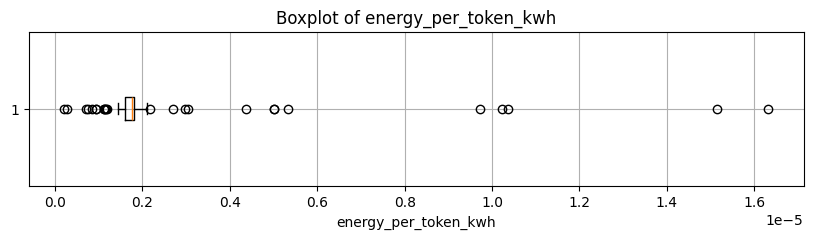

🔬 Scatter: Energy vs FLOPs...


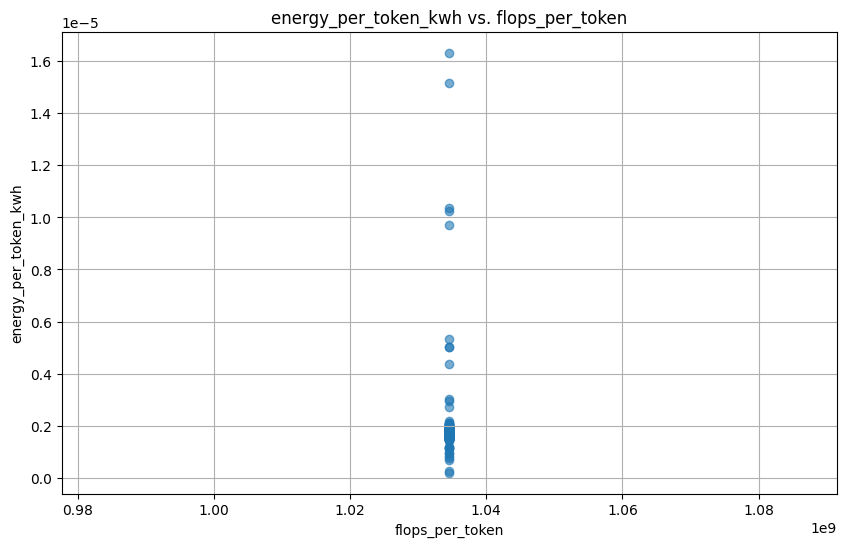

📈 Scatter: Divergence vs Batch Size...


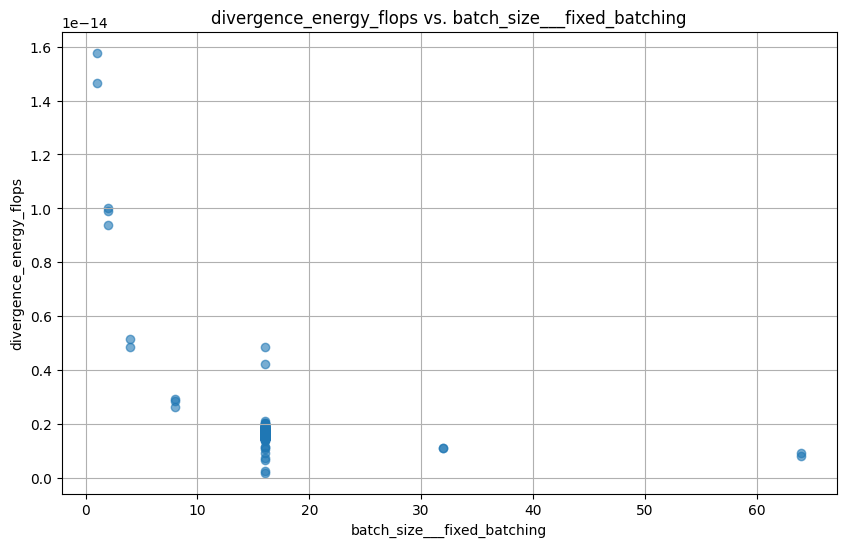

🔗 Correlation matrix...


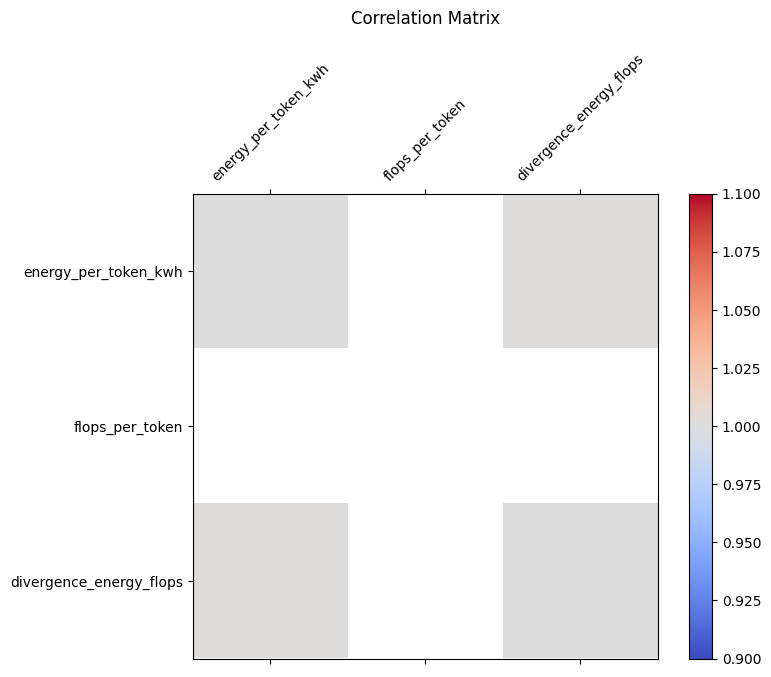

In [3]:
from scripts.b_exploratory_data_analysis import (
    plot_histogram,
    plot_boxplot,
    plot_scatter,
    plot_divergence,
    plot_correlation_matrix,
    plot_all_diagnostics
)

plot_all_diagnostics(df)

To do: 
- [ ] crop outliers temporarily -> look at closer grouped in more detail
- [ ] examine the divergence plot more

# Controlled Experiment Visualisation

NB: THE STD ERROR BAR EXTENDS BEYOND THE RAW OBSERVATIONS????

ADD LEGENDS TO ALL OF THEM!

Observations per class:
  No simulation total:     2
  In Latency (constant):   10
  In Latency (bursty):     104


NameError: name 'cls' is not defined

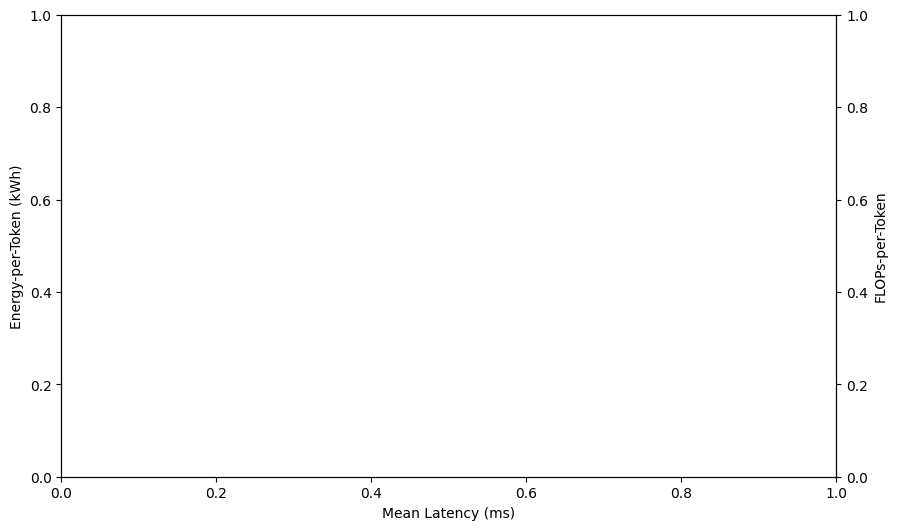

In [20]:
import numpy as np

import importlib
import scripts.c_controlled_exp_visualisations as viz
importlib.reload(viz)

from scripts.c_controlled_exp_visualisations import (
    plot_num_processes,
    plot_batching,
    plot_precision,
    plot_decoder_temperature,
    plot_decoder_topk_top_p,
    plot_latency,
    plot_all_vizs,
)

configs = ['num_processes', 'batching','precis', 'decoding', 'latency']
dfs = {config: df[df['config_name'].str.startswith(config)] for config in configs}


plot_latency(dfs)


In [30]:
def _plot_with_band(ax, raw_df, x_col, y_col, mean_df, mean_col, std_col,
                    color, raw_kwargs=None, band_alpha=0.2,
                    label_mean="Mean", label_band="±1 std", label_raw="Raw"):
    """
    Plot raw scatter and a smoothed mean ± std band on ax.
    Maps categorical x to numeric positions if needed.
    """
    raw_kwargs = raw_kwargs or {}

    # Determine positions for x-axis
    idx_str = mean_df.index.astype(str)
    try:
        positions = idx_str.astype(float)
    except ValueError:
        positions = np.arange(len(idx_str))
        ax.set_xticks(positions)
        ax.set_xticklabels(idx_str)
    # Map raw x to positions
    mapping = {str(v): p for v, p in zip(idx_str, positions)}
    raw_x = raw_df[x_col].astype(str).map(mapping)

    # Scatter raw points
    if label_raw:
        ax.scatter(raw_x, raw_df[y_col],
                   color=color, alpha=raw_kwargs.get('alpha',0.3),
                   marker=raw_kwargs.get('marker','o'),
                   label=label_raw)

    # Compute mean and std arrays
    mean_vals = mean_df[mean_col].values
    std_vals = mean_df[std_col].fillna(0).values
    lower = mean_vals - std_vals
    upper = mean_vals + std_vals

    if len(positions) > 1:
        # Smooth interpolation
        x_fine = np.linspace(positions.min(), positions.max(), 200)
        mean_fine = np.interp(x_fine, positions, mean_vals)
        low_fine = np.interp(x_fine, positions, lower)
        up_fine = np.interp(x_fine, positions, upper)
        # Plot mean line
        ax.plot(x_fine, mean_fine, linestyle='-', color=color, label=label_mean)
        # Plot band
        if label_band:
            ax.fill_between(x_fine, low_fine, up_fine, color=color, alpha=band_alpha, label=label_band)
    else:
        # Single point
        ax.plot(positions, mean_vals,
                marker=raw_kwargs.get('marker','o'), linestyle='-', color=color,
                label=label_mean)
        if label_band:
            ax.fill_between(positions, lower, upper, color=color, alpha=band_alpha, label=label_band)


In [ ]:
from matplotlib import cm

def classify_latency(df: pd.DataFrame) -> pd.DataFrame:
    """
    Given a DataFrame with these columns:
      - latency_simulation_simulate (bool)
      - latency_simulation_simulate_burst (bool)
      - latency_simulation_delay_min (float)
      - latency_simulation_delay_max (float)
      - flops_per_token
      - energy_per_token_kwh
    Returns a new DataFrame with boolean columns:
      - latency_constant
      - latency_bursty
      - one column per unique burst-range tuple (min,max)
    plus flops_per_token and energy_per_token_kwh.
    """
    df = df.copy()
    
    # Base flags
    bursty = df['latency_simulation_simulate_burst'].fillna(False)
    constant = ~bursty
    no_sim = ~df['latency_simulation_simulate'].fillna(False)

    # Combined columns
    df['latency_bursty'] = bursty | no_sim
    df['latency_constant'] = constant | no_sim

    # Identify unique burst ranges
    burst_ranges = (
        df[bursty][['latency_simulation_delay_min', 'latency_simulation_delay_max']]
        .drop_duplicates()
        .apply(tuple, axis=1)
        .tolist()
    )

    # Create one boolean column per range
    for dmin, dmax in burst_ranges:
        col_name = f"burst_{dmin}_{dmax}"
        df[col_name] = (
            df['latency_simulation_simulate_burst'] &
            (df['latency_simulation_delay_min'] == dmin) &
            (df['latency_simulation_delay_max'] == dmax)
        )

    keep_cols = [
        'flops_per_token',
        'energy_per_token_kwh',
        'latency_simulation_simulate',
        'latency_simulation_delay_min',
        'latency_simulation_delay_max',
    ]
    new_latency_cols = [
        'latency_constant', 
        'latency_bursty'
    ]
    burst_cols = [f"burst_{dmin}_{dmax}" for dmin, dmax in burst_ranges]

    result = df.loc[:, keep_cols + new_latency_cols + burst_cols]
    
    
    return result

def add_latency_numeric(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds 'latency_numeric' column to a DataFrame:
    - 0.0 if latency_simulation_simulate is False
    - else mean of latency_simulation_delay_min and _max
    """
    df = df.copy()
    df['latency_numeric'] = df.apply(
        lambda r: 0.0
            if not r.get('latency_simulation_simulate', False)
            else (float(r['latency_simulation_delay_min']) +
                float(r['latency_simulation_delay_max'])) / 2,
        axis=1
    )
    return df


df0 = dfs['latency']
df1 = add_latency_numeric(df0)   # now we inject latency_numeric into df1
df2 = classify_latency(df1)      # produces only flags + flops + energy
#plot_latency_classes(df2)

df2

InvalidIndexError: ['flops_per_token', 'energy_per_token_kwh', 'latency_simulation_simulate', 'latency_simulation_delay_min', 'latency_simulation_delay_max', 'latency_constant', 'latency_bursty', 'burst_0.1_0.2', 'burst_0.05_0.1', 'burst_0.4_0.5', 'burst_0.2_0.4']

In [ ]:

def plot_latency_classes(df: pd.DataFrame) -> None:
    """
    Plots energy-per-token and FLOPs-per-token against latency,
    separated by latency class indicators. Expects:
      - latency_numeric
      - latency_constant, latency_bursty
      - one or more burst_* columns
      - energy_per_token_kwh
      - flops_per_token
    """
    # Identify all latency class columns
    latency_class_cols = [col for col in df.columns if col.startswith("burst_")]
    n_classes = len(latency_class_cols)

    # Assign colors
    cmap = cm.get_cmap('Blues', n_classes + 1)
    colors = {cls: cmap(i + 1) for i, cls in enumerate(latency_class_cols)}  # skip lightest

    # Prepare plot
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()
    ax1.set_xlabel("Mean Latency (ms)")
    ax1.set_ylabel("Energy-per-Token (kWh)")
    ax2.set_ylabel("FLOPs-per-Token")

    # Plot each burst range class
    for cls in latency_class_cols:
        mask = df[cls]
        sub_df = df[mask]
        if sub_df.empty:
            continue
        c = colors[cls]

        # Raw scatter
        ax1.scatter(sub_df['latency_numeric'],
                    sub_df['energy_per_token_kwh'],
                    color=c, alpha=0.3, label=f"Raw energy ({cls})")

        # Group stats
        stats = (sub_df.groupby('latency_numeric')
                          .energy_per_token_kwh
                          .agg(['mean', 'std'])
                          .rename(columns={'mean': 'm', 'std': 's'}))
        if 0.0 not in stats.index and not sub_df[sub_df['latency_numeric'] == 0.0].empty:
            z = sub_df[sub_df['latency_numeric'] == 0.0].energy_per_token_kwh
            stats.loc[0.0] = [z.mean(), z.std()]
        stats = stats.sort_index()

        # Plot smooth band
        _plot_with_band(
            ax1, sub_df, 'latency_numeric', 'energy_per_token_kwh',
            stats, 'm', 's', c,
            raw_kwargs={'alpha': 0},
            label_mean=f"Mean energy ({cls})",
            label_band="±1 std"
        )

    # FLOPs curve
    fl = (df.groupby('latency_numeric')
            .flops_per_token
            .agg(['mean','std'])
            .rename(columns={'mean':'m','std':'s'}))
    fl = fl.sort_index()
    _plot_with_band(
        ax2, df, 'latency_numeric', 'flops_per_token',
        fl, 'm', 's', 'tab:purple',
        raw_kwargs={'alpha':0,'marker':'s'},
        label_mean="FLOPs (all latencies)"
    )

    # Final plot adjustments
    ax1.set_xlim(df['latency_numeric'].min(), df['latency_numeric'].max())
    ax1.legend(loc='best')
    ax1.set_title("Energy & FLOPs-per-Token vs Latency (Burst Ranges)")
    plt.tight_layout()
    plt.show()


,config_name,experiment_id,date_time,model,num_processes,batch_size___fixed_batching,decoder_temperature,decoder_top_k,decoder_top_p,latency_simulation_simulate,latency_simulation_delay_max,latency_simulation_delay_min,latency_simulation_simulate_burst,latency_simulation_burst_size,latency_simulation_burst_interval,fp_precision,quantization,load_in_8bit,load_in_4bit,total_input_tokens,total_generated_tokens,date_time,total_params,max_input_tokens,max_output_tokens,number_input_prompts,total_energy_kwh,total_energy_joules,flops,tokens_per_joule,joules_per_token,flops_per_joule,joules_per_flop,total_inference_time_sec,average_latency_ms_per_batch,throughput_queries_per_sec,throughput_tokens_per_sec,total_energy_kwh_process_0,total_energy_kwh_process_1,total_energy_kwh_process_2,total_energy_kwh_process_3,gpu_power_avg,ram_power_avg,cpu_energy_total,gpu_energy_total,decoder_config_decoding_mode,flops_per_token,energy_per_token_kwh,divergence_energy_flops,total_energy_kwh_mean,total_energy_kwh_std,total_inference_time_sec_mean,total_inference_time_sec_std,average_latency_ms_per_batch_mean,average_latency_ms_per_batch_std,throughput_queries_per_sec_mean,throughput_queries_per_sec_std,throughput_tokens_per_sec_mean,throughput_tokens_per_sec_std,cpu_energy_total_mean,cpu_energy_total_std,gpu_energy_total_mean,gpu_energy_total_std,flops_mean,flops_std,flops_per_token_mean,flops_per_token_std,energy_per_token_kwh_mean,energy_per_token_kwh_std,divergence_energy_flops_mean,divergence_energy_flops_std
87,latency_off,136,"April 17, 2025 at 04:59:03 AM",TinyLlama/TinyLlama-1.1B-Chat-v1.0,4,16,1.0,NaN,NaN,False,0.0,0.0,False,0,0.0,torch.float32,NaN,NaN,NaN,16384,16384,"April 17, 2025 at 04:59:03 AM",1100048384,128,128,128,0.028455,102439.166368,16949970993152,0.159939,6.252391,1.654638e+08,6.043619e-09,23.550336,2943.791975,5.435167,695.701333,0.005914,0.008805,0.005962,0.007775,573.881798,0.644925,0.003728,0.024709,NaN,1.034544e+09,0.000002,1.678783e-15,0.026946,0.002134,24.420067,1.229985,3052.508351,153.748173,5.248248,0.264343,671.775755,33.835876,0.003654,0.000106,0.023275,0.002028,1.694997e+13,0.0,1.034544e+09,0.0,0.000002,1.302731e-07,1.589742e-15,1.259232e-16
209,latency_off,270,"April 17, 2025 at 09:54:19 AM",TinyLlama/TinyLlama-1.1B-Chat-v1.0,4,16,1.0,NaN,NaN,False,0.0,0.0,False,0,0.0,torch.float32,NaN,NaN,NaN,16384,16384,"April 17, 2025 at 09:54:19 AM",1100048384,128,128,128,0.025437,91572.600438,16949970993152,0.178918,5.589148,1.850987e+08,5.402523e-09,25.289798,3161.224727,5.061330,647.850177,0.005825,0.007938,0.005873,0.005800,566.272465,0.649623,0.003579,0.021841,NaN,1.034544e+09,0.000002,1.500701e-15,0.026946,0.002134,24.420067,1.229985,3052.508351,153.748173,5.248248,0.264343,671.775755,33.835876,0.003654,0.000106,0.023275,0.002028,1.694997e+13,0.0,1.034544e+09,0.0,0.000002,1.302731e-07,1.589742e-15,1.259232e-16


In [6]:
df_temp.loc[
    (df["latency_simulation_simulate"] == True) & 
    (df["latency_simulation_simulate_burst"] == False),
    df.columns[df.columns.str.startswith("latency")]
]

/Users/henrybaker/miniconda3/envs/thesis/lib/python3.12/site-packages/executing/executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
/Users/henrybaker/miniconda3/envs/thesis/lib/python3.12/site-packages/executing/executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
/Users/henrybaker/miniconda3/envs/thesis/lib/python3.12/ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)
/Users/henrybaker/miniconda3/envs/thesis/lib/python3.12/site-packages/executing/executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
/Users/henrybaker/miniconda3/envs/thesis/lib/python3.12/ast.py:587: DeprecationWarning: Attribute s is depr

NameError: name 'df_temp' is not defined

to do:
- [ ] don't treat no simulation and simulation as categorically distinct, rather they are on a continuous number line, and the plots should reflect that
- [ ] get FLOPs to print just once, and the legend to only be taken from one axis 
- PRINT WITH NORMALISED AXIS!!!! - Plot the values as a percent of the mean to visualise their relative spread

TO DO: WORK OUT % OF TOTAL ENERGY CONSUMPTION / VARIANCE THAT CAN BE EXPLAINED BY TOTAL CONFIGS CHANGES VS BASELINE THAT IS MODEL DETERMINED

# Modeling

In [ ]:
from scripts.d_base_regression import run_full_regression_analysis, preprocess_data

df = preprocess_data(df)

# With default predictors
run_full_regression_analysis(df)

# With custom predictors
custom_predictors = ["batch_size_numeric", "C(fp_precision)", "C(quantization)"]
run_full_regression_analysis(df, predictors=custom_predictors)


In [ ]:
%run scripts/d_mixed_effects_model.py

In [ ]:
df['energy_per_token_kwh'].max() -  df['energy_per_token_kwh'].min() 

To do
- [ ] identify groupings:
   - [ ] use model (even though currently only one model)
   - [ ] use config_name and date_time
   - [ ] use decoder configs
   - [ ] latency configs 